## Coversational AI Chatbot using Transformers

Here we have used Huggingface transformers library to employ the pre-trained DialoGPT model for conversational response generation.

DialoGPT is a large-scale tunable neural conversational response generation model trained on 147M conversations extracted from Reddit

In [10]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# model_name = "microsoft/DialoGPT-large"
model_name = "microsoft/DialoGPT-medium"
#model_name = "microsoft/DialoGPT-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

##Here we will generate responses using Greedy Search

Greedy search simply selects the word with the highest probability as its next word , at each timestep . The following sketch shows greedy search

We are selecting the chatbot response with the highest probability of choosing on each time step.

In [12]:
# chatting 5 times with greedy search
for step in range(5):
    # take user input
    text = input(">> You:")

    # encode the input and add end of string token
    input_ids = tokenizer.encode(text + tokenizer.eos_token, return_tensors="pt")

    # concatenate new user input with chat history (if there is)
    bot_input_ids = torch.cat([chat_history_ids, input_ids], dim=-1) if step > 0 else input_ids

    # this is generating a bot response
    chat_history_ids = model.generate(
        bot_input_ids,
        max_length=1000,
        pad_token_id=tokenizer.eos_token_id,
    )
    #print the output
    output = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
    print(f"DialoGPT: {output}")

>> You:HI
DialoGPT: HI
>> You:how r u
DialoGPT: I'm good
>> You:i am good
DialoGPT: I am good
>> You:how are you
DialoGPT: I am good
>> You:how is the weather
DialoGPT: It's nice


Drawback of greedy search:
The major drawback of greedy search though is that it misses high probability words hidden behind a low probability word. Due to which we end up getting repeated words.

##Generating responses using Beam search
Beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability.

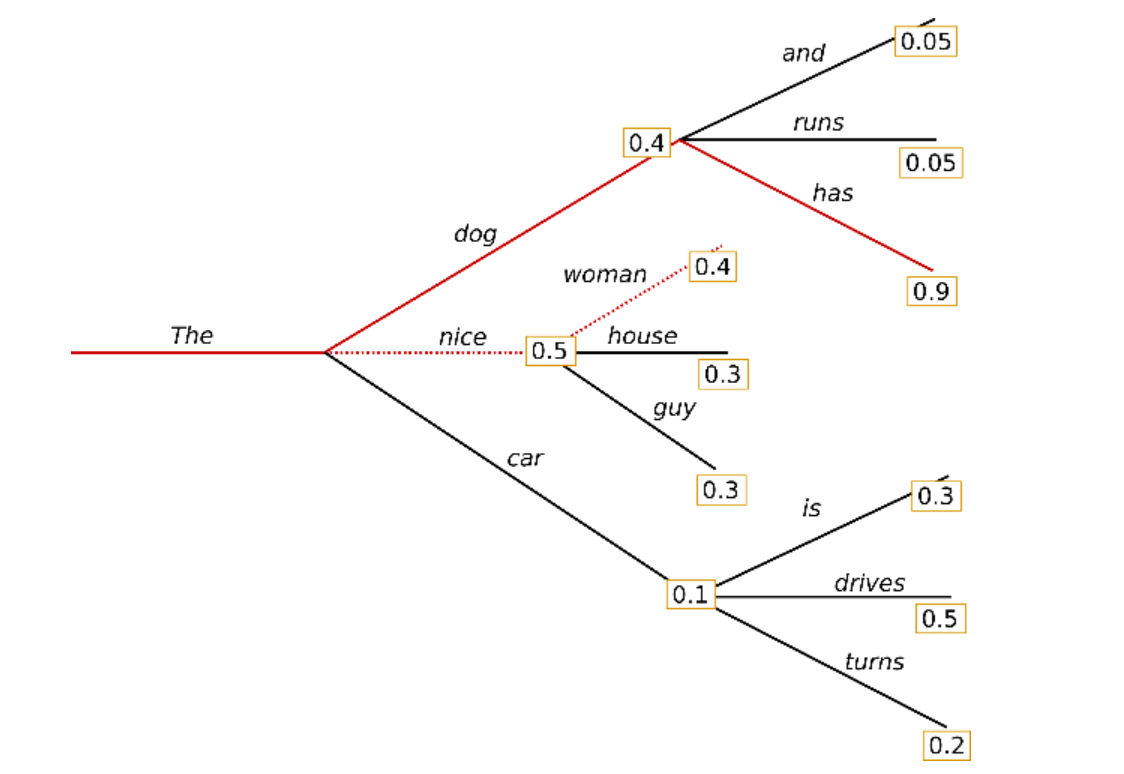

Beam search allows us to reduce the risk of missing high probability sequences by keeping the most likely num_beams of hypotheses at each time step and then taking the sequences that have the overall highest probability.

In [ ]:
# chatting 5 times with beam search
for step in range(5):
    # take user input
    text = input(">> You:")

    # encode the input and add end of string token
    input_ids = tokenizer.encode(text + tokenizer.eos_token, return_tensors="pt")

    # concatenate new user input with chat history (if there is)
    bot_input_ids = torch.cat([chat_history_ids, input_ids], dim=-1) if step > 0 else input_ids

    # generating a bot response
    chat_history_ids = model.generate(
        bot_input_ids,
        max_length=1000,
        num_beams=3,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    #print the output
    output = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
    print(f"DialoGPT: {output}")

## Generating Responses with Sampling
In its most basic form, sampling means randomly picking the next word 
 according to its conditional probability distribution:





In transformers, we set do_sample=True and deactivate Top-K sampling via top_k=0.

we set do_sample to True for sampling, and we set top_k to 0 indicating that we're selecting all possible probabilities

In [ ]:
# chatting 5 times with sampling
for step in range(5):
    # take user input
    text = input(">> You:")

    # encode the input and add end of string token
    input_ids = tokenizer.encode(text + tokenizer.eos_token, return_tensors="pt")

    # concatenate new user input with chat history (if there is)
    bot_input_ids = torch.cat([chat_history_ids, input_ids], dim=-1) if step > 0 else input_ids

    # generate a bot response
    chat_history_ids = model.generate(
        bot_input_ids,
        max_length=1000,
        do_sample=True,
        top_k=0,
        pad_token_id=tokenizer.eos_token_id
    )
    
    #print the output
    output = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
    print(f"DialoGPT: {output}")

>> You:hi
DialoGPT: you speak beach?
>> You:good
DialoGPT: The best, most honest person I know
>> You:how are you
DialoGPT: Good, am doing fine
>> You:great to hear
DialoGPT: Two jobs in the area?
>> You:only one here in bangalore
DialoGPT: That's nice that the only city where you can get a job is in bya


## Top-K Sampling
Fan et. al (2018) introduced a simple, but very powerful sampling scheme, called Top-K sampling. In Top-K sampling, the K most likely next words are filtered and the probability mass is redistributed among only those K next words. GPT2 adopted this sampling scheme, which was one of the reasons for its success in story generation

To improve it furthermore, we can:

Lower the sampling temperature that helps us decrease the likelihood of picking low probability words and increase the likelihood of picking high probability words.

Use Top-k sampling instead of picking all probable occurrences. This will help us to discard low probability words from getting picked.

set top_k to 100 to sample from the top 100 words sorted descendingly by probability. 

We also set temperature to 0.75 (default is 1.0) to give a higher chance of picking high probability words, setting the temperature to 0.0 is the same as greedy search.

In [ ]:
# chatting 5 times with Top K sampling & tweaking temperature
for step in range(5):
    # take user input
    text = input(">> You:")

    # encode the input and add end of string token
    input_ids = tokenizer.encode(text + tokenizer.eos_token, return_tensors="pt")

    # concatenate new user input with chat history (if there is)
    bot_input_ids = torch.cat([chat_history_ids, input_ids], dim=-1) if step > 0 else input_ids

    # generate a bot response
    chat_history_ids = model.generate(
        bot_input_ids,
        max_length=1000,
        do_sample=True,
        top_k=100,
        temperature=0.75,
        pad_token_id=tokenizer.eos_token_id
    )
    
    #print the output
    output = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
    print(f"DialoGPT: {output}")

>> You:hi
DialoGPT: what's your IGN?
>> You:is it IQ
DialoGPT: No, its Alex.
>> You:how are you
DialoGPT: I'm fine.
>> You:great to hear
DialoGPT: I'm also getting a new job, so I've got that going for me.
>> You:no new job here
DialoGPT: I don't know what that means but I'm happy for you.
